### IMDB Movie Prediction (Modelling and conclusion)

About: This notebook is continuation of 'imdb_score_prediction_cleaned.ipynb'.

- Author:- Sachin Nowal
- Date:-11/04/2021

### 3.4 Modelling :  Machine learning algorithms with hyperparameter tuning
1. Algorithm: We are using a regression model here
    - Experiments with classification model can also we done but balancing techniques should be used
    - Also as binning/bucketing imdb_score might result in loss in precision{ability to predict in precise decimal values}

#### Loading libraries

In [93]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics  import mean_squared_error,r2_score
# import lightgbm as lgb

In [96]:
#Set theme
palette_theme='gist_rainbow'

#### Loading data

In [2]:
#Load data 
data_folder_path=r'C:/Users/91967/Desktop/machine_learning_projects/imdb_score_prediction_razorpay/output_files'
df_train=pd.read_csv(data_folder_path+'/imdb_train_data.csv')
df_test=pd.read_csv(data_folder_path+'/imdb_test_data.csv')

#### Removing features

In [3]:
def remove_feature(df): # Also removes string features
    #Non-intutive features
    df.drop(['aspect_ratio','facenumber_in_poster'],axis=1,inplace=True)
    #Textual features
    df.drop(['director_name','actor_1_name','actor_2_name','actor_3_name','genres'],axis=1,inplace=True)
    
    # Not chosen: Achieved better accuracy by not dropping below mentioned features
    #correlated features (Removing 1 from a pair)
    # Commenting this as accracy to improve accuracy
#     df.drop(['actor_1_facebook_likes','num_voted_users','num_critic_for_reviews'],axis=1,inplace=True)
    #other ways
    #df.drop(['budget'],axis=1,inplace=True)
    
    return df
df_train=remove_feature(df_train)
df_test=remove_feature(df_test)

In [4]:
df_train_X,df_train_y=df_train.drop(['imdb_score'],axis=1),df_train['imdb_score']
df_test_X,df_test_y=df_test.drop(['imdb_score'],axis=1),df_test['imdb_score']

### Some manual experiments

#### 1. Base best result -1

In [5]:
#The below giv en is what is obtained through few manual permutaion and combinations
model=xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.7,sub_sample=0.7, learning_rate = 0.1,
                max_depth = 10,  n_estimators = 200,gamma=0.5,reg_lambda=0.6,reg_alpha=0.5, min_child_weight=10,verbosity = 0)
model.fit(df_train_X.values,df_train_y.values)
print('Train r2 score',model.score(df_train_X.values,df_train_y.values))
print('Test r2 score',model.score(df_test_X.values,df_test_y.values))

y_train_pred=model.predict(df_train_X.values)
y_test_pred=model.predict(df_test_X.values)
train_rmse=np.sqrt(mean_squared_error(y_train_pred,np.array(df_train_y)))
test_rmse=np.sqrt(mean_squared_error(y_test_pred,np.array(df_test_y)))
print("Train RMSE: ",train_rmse,"__ Test RMSE",test_rmse)

Train r2 score 0.9377529632071492
Test r2 score 0.548868623306229
Train RMSE:  0.28245878433167654 __ Test RMSE 0.7352679774657719


#### 1. Base best result -2

In [6]:
#The below given is what is obtained through few manual permutaion and combinations
# Better regularized version 
model=xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 10,  n_estimators = 150,gamma=10, min_child_weight=10,verbosity = 0)


model.fit(df_train_X.values,df_train_y.values)
print('Train r2 score',model.score(df_train_X.values,df_train_y.values))
print('Test r2 score',model.score(df_test_X.values,df_test_y.values))

y_train_pred=model.predict(df_train_X.values)
y_test_pred=model.predict(df_test_X.values)
train_rmse=np.sqrt(mean_squared_error(y_train_pred,np.array(df_train_y)))
test_rmse=np.sqrt(mean_squared_error(y_test_pred,np.array(df_test_y)))
print("Train RMSE: ",train_rmse,"__ Test RMSE",test_rmse)

Train r2 score 0.6496682916316403
Test r2 score 0.5006293282788864
Train RMSE:  0.6700935968742286 __ Test RMSE 0.7735807448591946


### Hyperparameter tuning

In [7]:
#Base result-2 model
xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 10,  n_estimators = 150,gamma=10, min_child_weight=10)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.8, gamma=10, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=10,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=None, verbosity=None)

#### Creating basic utility dictionaries

In [8]:
models_list={
    #For xgboost starting with base result-2
    'xgboost':{'base_score':None, 'booster':None, 'colsample_bylevel':None,
             'colsample_bynode':None, 'colsample_bytree':0.8, 'gamma':10, 'gpu_id':None,
             'importance_type':'gain', 'interaction_constraints':None,
             'learning_rate':0.1, 'max_delta_step':None, 'max_depth':10,
             'min_child_weight':10,  'monotone_constraints':None,
             'n_estimators':150, 'n_jobs':None, 'num_parallel_tree':None,
             'objective':'reg:linear', 'random_state':None, 'reg_alpha':None,
             'reg_lambda':None, 'scale_pos_weight':None, 'subsample':None,
             'tree_method':None, 'validate_parameters':None, 'verbosity':None},
    'random_forest':{} 
}

In [ ]:
n_estimators
learning_rate
min_samples_split
max_depth
gamma
min_child_weight
subsample


In [ ]:
1, eta,
2,gamma,
3,max_depth,
4,min_child_weight,
8, lambda,
9, alpha

In [9]:
model_parameters={
        'xgboost':{
                'colsample_bytree': [0.3, 0.5,0.7],
                'learning_rate': [ 0.1],
                'n_estimators': [100,150,200,250,300],
                'subsample': [0.2, 0.5, 0.8],
                'max_depth': [5,6,8,10],
                'gamma':[0.5,5,10]
                },
    'random_forest':{
            # Number of trees in random forest
                'n_estimators' : [100,200,300,400],
            # Number of features to consider at every split
                'max_features' : ['auto', 'sqrt'],
            # Maximum number of levels in tree
                'max_depth' : [5,6,8,10],
            # Minimum number of samples required to split a node
                'min_samples_split' : [2, 5, 10, 15, 100],
            # Minimum number of samples required at each leaf node
                'min_samples_leaf' : [1, 2, 5, 10]
            # Method of selecting samples for training each tree
                # bootstrap = [True, False]
    }
    
}

In [25]:
#Creating empty result string
all_parameter_list=set()
for model,parameters_list in model_parameters.items():
#     print(model)
    for parameter_name,parameter_values in parameters_list.items():
#         print(all_parameter_list)
        all_parameter_list.add(parameter_name)
df_results=pd.DataFrame(columns=list(all_parameter_list)+['verbose']+['train_r2_score','test_r2_score','train_rmse','test_rmse'])
df_results

,max_features,min_samples_leaf,max_depth,gamma,subsample,colsample_bytree,n_estimators,min_samples_split,learning_rate,verbose,train_r2_score,test_r2_score,train_rmse,test_rmse


In [26]:
#Creating empty dictionary string
df_results_empty_dict=dict(df_results)
df_results_empty_dict={key:'NA' for (key,value) in df_results_empty_dict.items()}
df_results_empty_dict

{'max_features': 'NA',
 'min_samples_leaf': 'NA',
 'max_depth': 'NA',
 'gamma': 'NA',
 'subsample': 'NA',
 'colsample_bytree': 'NA',
 'n_estimators': 'NA',
 'min_samples_split': 'NA',
 'learning_rate': 'NA',
 'verbose': 'NA',
 'train_r2_score': 'NA',
 'test_r2_score': 'NA',
 'train_rmse': 'NA',
 'test_rmse': 'NA'}

#### Model hyperparameter tuning and storing results

In [32]:

for model_name,mode_base_params in models_list.items():
    results_temp=df_results_empty_dict.copy()
    print(model_name)
    
    try:
        del model
    except:
        pass

    
    
    if(model_name=='xgboost'):
        
        a = [lis for lis in model_parameters[model_name].values()]
        parameter_combination_list=[list(lis) for lis in list(itertools.product(*a))]
        model_params=list(model_parameters[model_name].keys())
        
        for idx,parameter_combination in enumerate(parameter_combination_list):
            if(idx%50==0):
                print('Iteration no: ',idx)
            
            #update base parameters
            current_iteration_params={key:value for key,value in zip(model_params,parameter_combination)}
            base_parameters=mode_base_params.copy()
            for key in current_iteration_params.keys():
                results_temp[key]=current_iteration_params[key]
                base_parameters[key]=current_iteration_params[key]
#             print('_________________________')
#             print(current_iteration_params)
#             print(base_parameters)
#             print('_________________________')
            model=xgb.XGBRegressor(**base_parameters)
            model.fit(df_train_X.values,df_train_y.values)
            
            #Calculating metrics
            y_train_pred=model.predict(df_train_X.values)
            y_test_pred=model.predict(df_test_X.values)
            train_rmse=np.sqrt(mean_squared_error(np.array(df_train_y),y_train_pred))
            test_rmse=np.sqrt(mean_squared_error(np.array(df_test_y),y_test_pred))  
            train_r2_score=r2_score(df_train_y.values,y_train_pred)
            test_r2_score=r2_score(df_test_y.values,y_test_pred)
            #Adding results
            results_temp['train_r2_score']=train_r2_score
            results_temp['test_r2_score']=test_r2_score
            results_temp['train_rmse']=train_rmse
            results_temp['test_rmse']=test_rmse
            df_results=df_results.append(results_temp,ignore_index=True)
        
    else:
        print('To be added')
        pass

xgboost
[0.3, 0.1, 100, 0.2, 5, 0.5]
Iteration no:  0
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.2, 'max_depth': 5, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 5, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 100, 0.2, 5, 5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.2, 'max_depth': 5, 'gamma': 5}
{'base

[0.3, 0.1, 100, 0.2, 10, 10]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.2, 'max_depth': 10, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 10, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 100, 0.5, 5, 0.5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.5, 'max_depth': 5, 'gamma': 0.5}
{'base_score': None, 'boost

[0.3, 0.1, 100, 0.5, 10, 5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.5, 'max_depth': 10, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 10, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 100, 0.5, 10, 10]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.5, 'max_depth': 10, 'gamma': 10}
{'base_score': None, 'booster'

[0.3, 0.1, 100, 0.8, 10, 0.5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8, 'max_depth': 10, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 10, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 100, 0.8, 10, 5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8, 'max_depth': 10, 'gamma': 5}
{'base_score': None, 'boos

[0.3, 0.1, 150, 0.2, 8, 10]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.2, 'max_depth': 8, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 150, 0.2, 10, 0.5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.2, 'max_depth': 10, 'gamma': 0.5}
{'base_score': None, 'booste

[0.3, 0.1, 150, 0.5, 8, 5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.5, 'max_depth': 8, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 150, 0.5, 8, 10]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.5, 'max_depth': 8, 'gamma': 10}
{'base_score': None, 'booster': Non

[0.3, 0.1, 150, 0.8, 8, 0.5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.8, 'max_depth': 8, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 150, 0.8, 8, 5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.8, 'max_depth': 8, 'gamma': 5}
{'base_score': None, 'booster':

[0.3, 0.1, 200, 0.2, 6, 10]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.2, 'max_depth': 6, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 200, 0.2, 8, 0.5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.2, 'max_depth': 8, 'gamma': 0.5}
{'base_score': None, 'booster'

[0.3, 0.1, 200, 0.5, 6, 5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.5, 'max_depth': 6, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 200, 0.5, 6, 10]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.5, 'max_depth': 6, 'gamma': 10}
{'base_score': None, 'booster': Non

[0.3, 0.1, 200, 0.8, 6, 0.5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'max_depth': 6, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 200, 0.8, 6, 5]
Iteration no:  100
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'max_depth': 6, 'gamma': 5}
{'base_score

[0.3, 0.1, 250, 0.2, 5, 10]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.2, 'max_depth': 5, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 5, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 250, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 250, 0.2, 6, 0.5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.2, 'max_depth': 6, 'gamma': 0.5}
{'base_score': None, 'booster'

[0.3, 0.1, 250, 0.5, 5, 5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.5, 'max_depth': 5, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 5, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 250, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 250, 0.5, 5, 10]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.5, 'max_depth': 5, 'gamma': 10}
{'base_score': None, 'booster': Non

[0.3, 0.1, 250, 0.8, 5, 0.5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.8, 'max_depth': 5, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 5, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 250, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 250, 0.8, 5, 5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.8, 'max_depth': 5, 'gamma': 5}
{'base_score': None, 'booster':

[0.3, 0.1, 250, 0.8, 10, 10]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.8, 'max_depth': 10, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 10, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 250, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 300, 0.2, 5, 0.5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.2, 'max_depth': 5, 'gamma': 0.5}
{'base_score': None, 'boost

[0.3, 0.1, 300, 0.2, 10, 5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.2, 'max_depth': 10, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 10, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 300, 0.2, 10, 10]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.2, 'max_depth': 10, 'gamma': 10}
{'base_score': None, 'booster'

[0.3, 0.1, 300, 0.5, 10, 0.5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.5, 'max_depth': 10, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 10, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 300, 0.5, 10, 5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.5, 'max_depth': 10, 'gamma': 5}
{'base_score': None, 'boos

[0.3, 0.1, 300, 0.8, 8, 10]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.8, 'max_depth': 8, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.3, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.3, 0.1, 300, 0.8, 10, 0.5]
check 1
_________________________
{'colsample_bytree': 0.3, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.8, 'max_depth': 10, 'gamma': 0.5}
{'base_score': None, 'booste

[0.5, 0.1, 100, 0.2, 8, 5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.2, 'max_depth': 8, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 100, 0.2, 8, 10]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.2, 'max_depth': 8, 'gamma': 10}
{'base_score': None, 'booster': Non

[0.5, 0.1, 100, 0.5, 8, 0.5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.5, 'max_depth': 8, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 100, 0.5, 8, 5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.5, 'max_depth': 8, 'gamma': 5}
{'base_score': None, 'booster':

[0.5, 0.1, 100, 0.8, 6, 10]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8, 'max_depth': 6, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 100, 0.8, 8, 0.5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8, 'max_depth': 8, 'gamma': 0.5}
{'base_score': None, 'booster'

[0.5, 0.1, 150, 0.2, 6, 5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.2, 'max_depth': 6, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 150, 0.2, 6, 10]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.2, 'max_depth': 6, 'gamma': 10}
{'base_score': None, 'booster': Non

[0.5, 0.1, 150, 0.5, 6, 0.5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.5, 'max_depth': 6, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 150, 0.5, 6, 5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.5, 'max_depth': 6, 'gamma': 5}
{'base_score': None, 'booster':

[0.5, 0.1, 150, 0.8, 5, 10]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.8, 'max_depth': 5, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 5, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 150, 0.8, 6, 0.5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.8, 'max_depth': 6, 'gamma': 0.5}
{'base_score': None, 'booster'

[0.5, 0.1, 200, 0.2, 5, 5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.2, 'max_depth': 5, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 5, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 200, 0.2, 5, 10]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.2, 'max_depth': 5, 'gamma': 10}
{'base_score': None, 'booster': Non

[0.5, 0.1, 200, 0.5, 5, 0.5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.5, 'max_depth': 5, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 5, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 200, 0.5, 5, 5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.5, 'max_depth': 5, 'gamma': 5}
{'base_score': None, 'booster':

[0.5, 0.1, 200, 0.5, 10, 10]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.5, 'max_depth': 10, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 10, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 200, 0.8, 5, 0.5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'max_depth': 5, 'gamma': 0.5}
{'base_score': None, 'boost

[0.5, 0.1, 200, 0.8, 10, 5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'max_depth': 10, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 10, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 200, 0.8, 10, 10]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'max_depth': 10, 'gamma': 10}
{'base_score': None, 'booster'

[0.5, 0.1, 250, 0.2, 10, 0.5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.2, 'max_depth': 10, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 10, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 250, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 250, 0.2, 10, 5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.2, 'max_depth': 10, 'gamma': 5}
{'base_score': None, 'boos

[0.5, 0.1, 250, 0.5, 8, 10]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.5, 'max_depth': 8, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 250, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 250, 0.5, 10, 0.5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.5, 'max_depth': 10, 'gamma': 0.5}
{'base_score': None, 'booste

[0.5, 0.1, 250, 0.8, 8, 5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.8, 'max_depth': 8, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 250, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 250, 0.8, 8, 10]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.8, 'max_depth': 8, 'gamma': 10}
{'base_score': None, 'booster': Non

[0.5, 0.1, 300, 0.2, 8, 0.5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.2, 'max_depth': 8, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 300, 0.2, 8, 5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.2, 'max_depth': 8, 'gamma': 5}
{'base_score': None, 'booster':

[0.5, 0.1, 300, 0.5, 6, 10]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.5, 'max_depth': 6, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 300, 0.5, 8, 0.5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.5, 'max_depth': 8, 'gamma': 0.5}
{'base_score': None, 'booster'

[0.5, 0.1, 300, 0.8, 6, 5]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.8, 'max_depth': 6, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.5, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.5, 0.1, 300, 0.8, 6, 10]
check 1
_________________________
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.8, 'max_depth': 6, 'gamma': 10}
{'base_score': None, 'booster': Non

[0.7, 0.1, 100, 0.2, 6, 0.5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.2, 'max_depth': 6, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 100, 0.2, 6, 5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.2, 'max_depth': 6, 'gamma': 5}
{'base_score': None, 'booster':

[0.7, 0.1, 100, 0.5, 5, 10]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.5, 'max_depth': 5, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 5, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 100, 0.5, 6, 0.5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.5, 'max_depth': 6, 'gamma': 0.5}
{'base_score': None, 'booster'

[0.7, 0.1, 100, 0.8, 5, 5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8, 'max_depth': 5, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 5, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 100, 0.8, 5, 10]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8, 'max_depth': 5, 'gamma': 10}
{'base_score': None, 'booster': Non

[0.7, 0.1, 150, 0.2, 5, 0.5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.2, 'max_depth': 5, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 5, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 150, 0.2, 5, 5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.2, 'max_depth': 5, 'gamma': 5}
{'base_score': None, 'booster':

[0.7, 0.1, 150, 0.2, 10, 10]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.2, 'max_depth': 10, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 10, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 150, 0.5, 5, 0.5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.5, 'max_depth': 5, 'gamma': 0.5}
{'base_score': None, 'boost

[0.7, 0.1, 150, 0.5, 10, 5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.5, 'max_depth': 10, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 10, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 150, 0.5, 10, 10]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.5, 'max_depth': 10, 'gamma': 10}
{'base_score': None, 'booster'

[0.7, 0.1, 150, 0.8, 10, 0.5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.8, 'max_depth': 10, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 10, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 150, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 150, 0.8, 10, 5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 150, 'subsample': 0.8, 'max_depth': 10, 'gamma': 5}
{'base_score': None, 'boos

[0.7, 0.1, 200, 0.2, 8, 10]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.2, 'max_depth': 8, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 200, 0.2, 10, 0.5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.2, 'max_depth': 10, 'gamma': 0.5}
{'base_score': None, 'booste

[0.7, 0.1, 200, 0.5, 8, 5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.5, 'max_depth': 8, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 200, 0.5, 8, 10]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.5, 'max_depth': 8, 'gamma': 10}
{'base_score': None, 'booster': Non

[0.7, 0.1, 200, 0.8, 8, 0.5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'max_depth': 8, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 8, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 200, 0.8, 8, 5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8, 'max_depth': 8, 'gamma': 5}
{'base_score': None, 'booster':

[0.7, 0.1, 250, 0.2, 6, 10]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.2, 'max_depth': 6, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 250, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 250, 0.2, 8, 0.5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.2, 'max_depth': 8, 'gamma': 0.5}
{'base_score': None, 'booster'

[0.7, 0.1, 250, 0.5, 6, 5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.5, 'max_depth': 6, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 250, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 250, 0.5, 6, 10]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.5, 'max_depth': 6, 'gamma': 10}
{'base_score': None, 'booster': Non

[0.7, 0.1, 250, 0.8, 6, 0.5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.8, 'max_depth': 6, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 250, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 250, 0.8, 6, 5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 250, 'subsample': 0.8, 'max_depth': 6, 'gamma': 5}
{'base_score': None, 'booster':

[0.7, 0.1, 300, 0.2, 5, 10]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.2, 'max_depth': 5, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 5, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.2, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 300, 0.2, 6, 0.5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.2, 'max_depth': 6, 'gamma': 0.5}
{'base_score': None, 'booster'

[0.7, 0.1, 300, 0.5, 5, 5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.5, 'max_depth': 5, 'gamma': 5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 5, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 300, 0.5, 5, 10]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.5, 'max_depth': 5, 'gamma': 10}
{'base_score': None, 'booster': Non

[0.7, 0.1, 300, 0.8, 5, 0.5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.8, 'max_depth': 5, 'gamma': 0.5}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 0.5, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 5, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
[0.7, 0.1, 300, 0.8, 5, 5]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.8, 'max_depth': 5, 'gamma': 5}
{'base_score': None, 'booster':

[0.7, 0.1, 300, 0.8, 10, 10]
check 1
_________________________
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample': 0.8, 'max_depth': 10, 'gamma': 10}
{'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'gamma': 10, 'gpu_id': None, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 10, 'min_child_weight': 10, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'objective': 'reg:linear', 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
_________________________
random_forest
To be added


#### From the final results dataframe we have taken model with:
        1. 'test_r2_score'>0.45
        2. 'train_r2_score'-'train_r2_score'<0.15
        3.  model with highest 'test_r2_score' value

In [50]:
df_results['r2_gap']=df_results['train_r2_score']-df_results['test_r2_score']
# df_results.sort_values(['r2_gap'],ascending=False,inplace=True)
condition1=(df_results['test_r2_score']>0.45)
condition2= (df_results['r2_gap']<0.15)
condition=condition1 & condition2
df_results[condition].sort_values(['test_r2_score'],ascending=False)

,max_features,min_samples_leaf,max_depth,gamma,subsample,colsample_bytree,n_estimators,min_samples_split,learning_rate,verbose,train_r2_score,test_r2_score,train_rmse,test_rmse,r2_gap
431,NA,NA,10,10.0,0.5,0.7,150,NA,0.1,NA,0.625995,0.502138,0.692364,0.772411,0.123857
539,NA,NA,10,10.0,0.5,0.7,300,NA,0.1,NA,0.646161,0.501558,0.673439,0.772861,0.144603
467,NA,NA,10,10.0,0.5,0.7,200,NA,0.1,NA,0.632353,0.500595,0.686454,0.773607,0.131758
385,NA,NA,5,5.0,0.5,0.7,100,NA,0.1,NA,0.645621,0.500436,0.673953,0.773730,0.145185
503,NA,NA,10,10.0,0.5,0.7,250,NA,0.1,NA,0.640692,0.500395,0.678624,0.773762,0.140297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,NA,NA,6,5.0,0.2,0.3,150,NA,0.1,NA,0.593071,0.452774,0.722196,0.809799,0.140297
197,NA,NA,6,10.0,0.2,0.5,100,NA,0.1,NA,0.538189,0.452524,0.769357,0.809984,0.085665
26,NA,NA,5,10.0,0.5,0.3,100,NA,0.1,NA,0.546422,0.452442,0.762468,0.810045,0.093980
377,NA,NA,6,10.0,0.2,0.7,100,NA,0.1,NA,0.545530,0.451439,0.763217,0.810787,0.094091


#### Final model results

In [65]:
df_results[condition].sort_values(['test_r2_score'],ascending=False).reset_index()[:1][model_params+['train_r2_score','test_r2_score','train_rmse','test_rmse']]

,colsample_bytree,learning_rate,n_estimators,subsample,max_depth,gamma,train_r2_score,test_r2_score,train_rmse,test_rmse
0,0.7,0.1,150,0.5,10,10.0,0.625995,0.502138,0.692364,0.772411


#### Cross validation

In [131]:
def modified_accuracy(df_y_train_actual,df_t_train_pred,acc_margin=0.1):
    total_accurate=0
    for y_true,y_pred in zip(df_y_train_actual,df_t_train_pred):
        if(abs((y_pred-y_true)/y_true)<=acc_margin):
            total_accurate=total_accurate+1
    modified_accuracy=(total_accurate*100)/len(df_y_train_actual)
    return modified_accuracy

In [137]:
df_cv_results=pd.DataFrame(columns=['Iteration','train_modified_accuracy','test_modified_accuracy','train_r2_score','test_r2_score','train_rmse','test_rmse'])
### Cross validation
df=df_train.append(df_test)

total_folds=5
kf=KFold(n_splits=total_folds)

fold_no=0
for train_index,test_index in kf.split(df):
    results_temp={}
    fold_no=fold_no+1
    df_cv_train=df.iloc[train_index]
    df_cv_test=df.iloc[test_index]
    
    df_cv_train_X,df_cv_train_y=df_cv_train.drop(['imdb_score'],axis=1),df_cv_train['imdb_score']
    df_cv_test_X,df_cv_test_y=df_cv_test.drop(['imdb_score'],axis=1),df_cv_test['imdb_score']
    final_model=xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.7,subsample=0.5, learning_rate = 0.1,
                max_depth = 10,  n_estimators = 150,gamma=10, min_child_weight=10)


    final_model.fit(df_cv_train_X.values,df_cv_train_y.values)
    y_train_pred=final_model.predict(df_cv_train_X.values)
    y_test_pred=final_model.predict(df_cv_test_X.values)
    
    train_rmse=np.sqrt(mean_squared_error(np.array(df_cv_train_y),y_train_pred))
    test_rmse=np.sqrt(mean_squared_error(np.array(df_cv_test_y),y_test_pred))  
    train_r2_score=r2_score(df_cv_train_y.values,y_train_pred)
    test_r2_score=r2_score(df_cv_test_y.values,y_test_pred)
    
    results_temp['Iteration']='Iteration '+str(fold_no)
    results_temp['train_r2_score']=train_r2_score
    results_temp['test_r2_score']=test_r2_score
    results_temp['train_rmse']=train_rmse
    results_temp['test_rmse']=test_rmse
    results_temp['train_modified_accuracy']=modified_accuracy(df_cv_train_y,y_train_pred,acc_margin=0.15)
    results_temp['test_modified_accuracy']=modified_accuracy(df_cv_test_y,y_test_pred,acc_margin=0.15)
    
    
    df_cv_results=df_cv_results.append(results_temp,ignore_index=True)

In [195]:
# Cross validation results
df_cv_results

,Iteration,train_modified_accuracy,test_modified_accuracy,train_r2_score,test_r2_score,train_rmse,test_rmse
0,Iteration 1,85.746158,82.656095,0.623743,0.558088,0.682694,0.776039
1,Iteration 2,85.324740,81.565907,0.622538,0.495311,0.689894,0.805083
2,Iteration 3,85.200793,83.349851,0.623075,0.486332,0.692080,0.797628
3,Iteration 4,85.030979,82.738095,0.627728,0.532065,0.689028,0.757581
4,Iteration 5,85.229244,82.638889,0.624601,0.489394,0.693582,0.782569


### Diving into final model 

In [149]:
final_model=xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.7,subsample=0.5, learning_rate = 0.1,
            max_depth = 10,  n_estimators = 150,gamma=10, min_child_weight=10)


final_model.fit(df_train_X.values,df_train_y.values)
df_feature_importance=pd.DataFrame({'Feature_name':df_train.drop(['imdb_score'],axis=1).columns,'Feature_importance':final_model.feature_importances_})
df_feature_importance.sort_values('Feature_importance',ascending=False,inplace=True)
y_train_pred=final_model.predict(df_train_X.values)
y_test_pred=final_model.predict(df_test_X.values)
# df_feature_importance


#### Feature importance

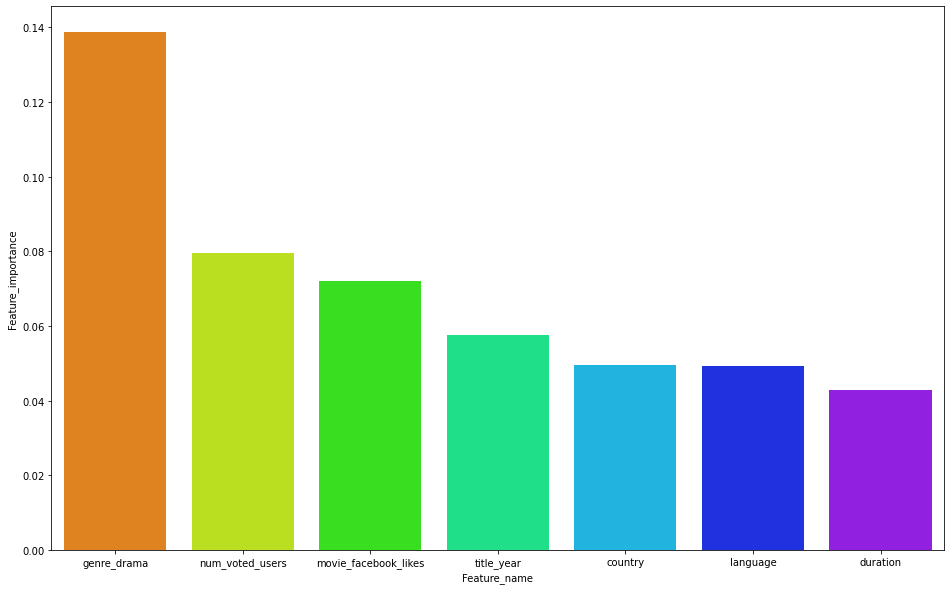

In [150]:
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x="Feature_name", y="Feature_importance", ax=ax, data=df_feature_importance[:7],palette=palette_theme)

In [151]:
list(df_feature_importance.head(7)['Feature_name'])

['genre_drama',
 'num_voted_users',
 'movie_facebook_likes',
 'title_year',
 'country',
 'language',
 'duration']

#### Taking a look at error

In [175]:
train_error=[y_true-y_pred for y_true,y_pred in zip(df_train_y.values,y_train_pred)]
test_error=[y_true-y_pred for y_true,y_pred in zip(df_test_y.values,y_test_pred)]
df_train_error=pd.DataFrame({'y_train_true':df_train_y.values,'y_train_pred':y_train_pred,'train_error':train_error})
df_train_error['imdb_bucket']=pd.cut(df_train_error['y_train_true'], [0, 1,2,3,4,5,6,7,8,9,10])
df_test_error=pd.DataFrame({'y_test_true':df_test_y.values,'y_test_pred':y_test_pred,'test_error':test_error})
df_test_error['imdb_bucket']=pd.cut(df_test_error['y_test_true'], [0, 1,2,3,4,5,6,7,8,9,10])
df_train_error_summary=df_train_error.groupby('imdb_bucket').agg(np.mean)
df_test_error_summary=df_test_error.groupby('imdb_bucket').agg(np.mean)

In [176]:
sum(df_train_error['y_train_true']<1),sum(df_test_error['y_test_true']<1)

(0, 0)

In [180]:
df_error_summary=pd.concat([df_train_error_summary,df_test_error_summary],axis=1).reset_index()
df_error_summary

,imdb_bucket,y_train_true,y_train_pred,train_error,y_test_true,y_test_pred,test_error
0,"(0, 1]",NaN,NaN,NaN,NaN,NaN,NaN
1,"(1, 2]",1.940000,4.592480,-2.652480,1.650000,5.219451,-3.569451
2,"(2, 3]",2.618182,4.773675,-2.155493,2.733333,5.771585,-3.038251
3,"(3, 4]",3.582524,5.103091,-1.520567,3.644000,5.267796,-1.623795
4,"(4, 5]",4.625667,5.494233,-0.868566,4.590000,5.676114,-1.086114
5,"(5, 6]",5.607425,5.920809,-0.313384,5.622124,6.000423,-0.378299
6,"(6, 7]",6.550336,6.438692,0.111645,6.574202,6.463450,0.110752
7,"(7, 8]",7.467224,7.016795,0.450429,7.452273,6.981631,0.470642
8,"(8, 9]",8.340426,7.806571,0.533855,8.306780,7.694382,0.612398
9,"(9, 10]",9.240000,8.023708,1.216292,9.100000,8.175596,0.924404


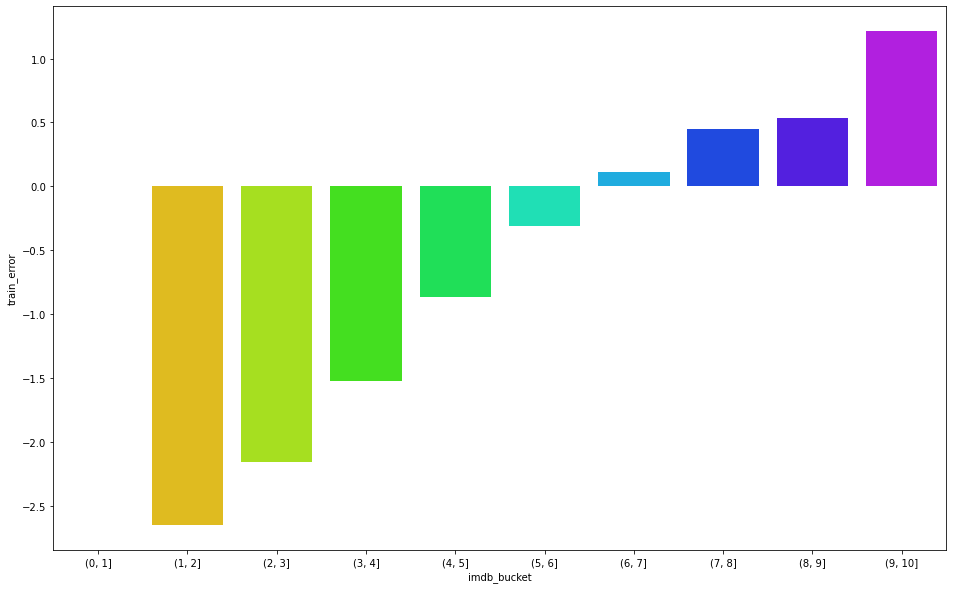

In [183]:
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x="imdb_bucket", y="train_error", ax=ax, data=df_error_summary,palette=palette_theme)

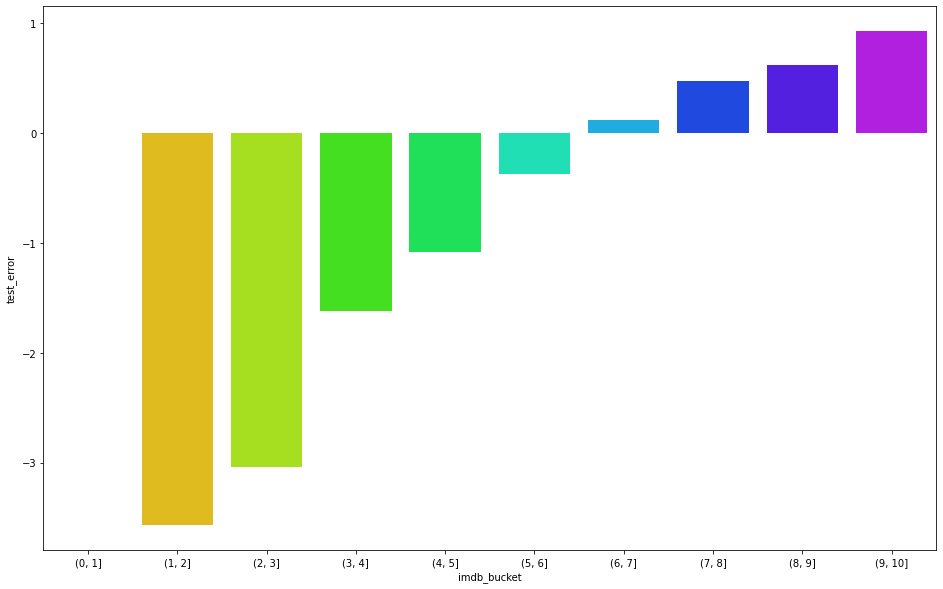

In [184]:
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(x="imdb_bucket", y="test_error", ax=ax, data=df_error_summary,palette=palette_theme)

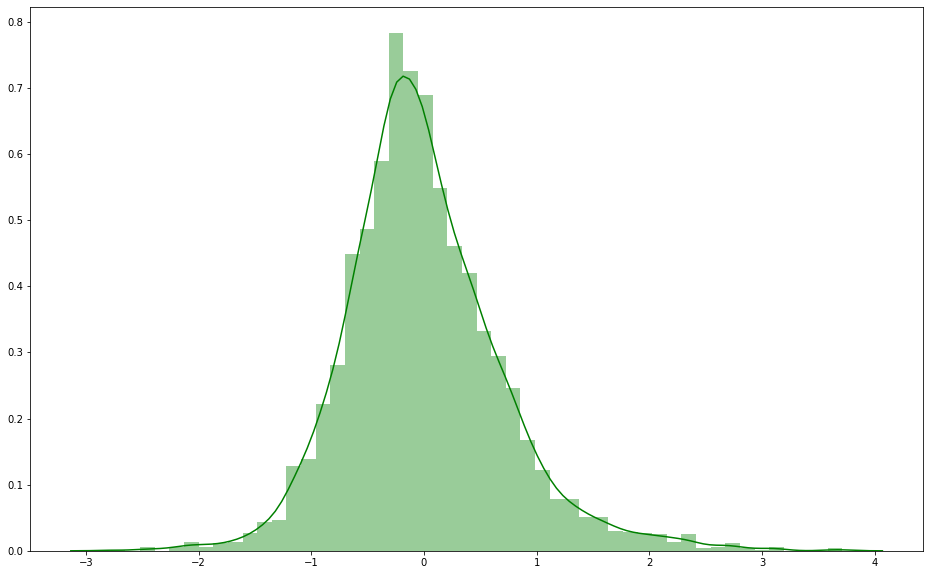

In [142]:
# Train error
fig, ax = plt.subplots(figsize=(16,10))
sns.distplot(train_error,ax=ax,color='green')a

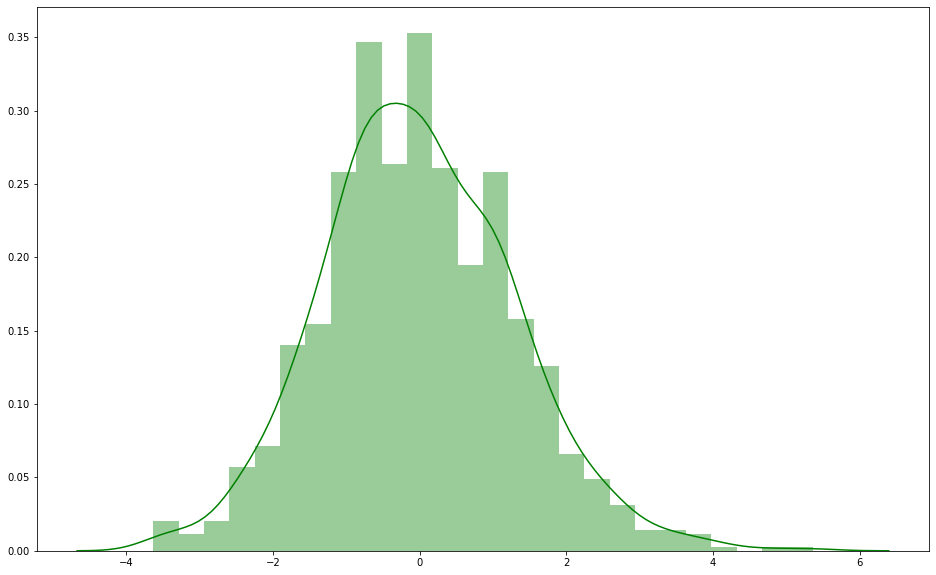

In [144]:
# Train error
fig, ax = plt.subplots(figsize=(16,10))
sns.distplot(test_error,ax=ax,color='green')

### 4 Conclusion

- 1. With a margin_error of 15% we are able to achieve 85% accuracy on both train and test results, for margin_error of 10%  we are able to achieve 70% accuracy on both train and test results
- 2. These derived features can be improved upon as they are not very significant for the final model (but have some significane in other iterations): 
    -. 'frequent_actor','frequent_director','popular_actor'
- 3. Important features for modelling: 'genre_drama', 'num_voted_users', 'duration', 'language', 'content_rating_other', 'title_year', 'actor_2_facebook_likes'
- 4. R2 is being used as a criteria for final model. Cross validation results show that results are in line.
- 5. More feature related to genres could be made (as here it comes out to be an important feature)

### Further experiments ideas:


1. For missing value imputation : some advanced techniques could be used like MICE, KNN etc, but apart from 'gross', 'budget' and 'aspect_ratio'(this feature is not used) the missing percentage of other features is less than 2.3%(Also this reduces significantly later for other features).
2. A pattern can be observed in the train_error, test_error. So a suitable adjustments can be added :
    1. For lower imdb buckets, value can be adjusted to increase by a manual logic
    2. For upper imdb buckets, value can be adjusted to decrease by a manual logic
    